# Notebook Overview
# Load And Test Trained Model

## key objectives:
- Loading a pre-trained sentiment analysis model
- Validating the model's functionality
- Analyzing training performance through visualizations

# Cell 1: Imports
This code imports necessary libraries and modules for setting up the sentiment analysis project, including the setup for importing local project files, managing paths, and preparing for model training and evaluation.
1. **Library Imports:**
2. **Project Path Setup:**
3. **Imports from Local Modules:**
4. **Path Setup for Models:**


In [4]:
import os
import sys
import json
import tensorflow as tf
from transformers import DistilBertTokenizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
project_root = '/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio'
sys.path.insert(0, project_root)
os.chdir('../')
from models.sentiment_model import EnhancedDistilBertForSentiment, ModelTrainer
from config.model_config import Config
from main import SentimentAnalyzer
from models.modelPersistence import ModelPersistence
from utils.modelEvaluator import ModelEvaluator
from data.data_processing import DataProcessor

2024-12-31 16:16:47.456030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cell 2: Model Loading and Initialization

- Loading Saved Model State
- Component Extraction
- Classifier Initialization

In [6]:
modelPersistence = ModelPersistence()

model_dir = "/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models"
version = "6_0_0"
epoch = 5
model_path = os.path.join(model_dir, f"model_v{version}_epoch{epoch}")

# Load the model state
loaded_state = modelPersistence.load_model_state(model_path)

# Extract components
model = loaded_state['model']
tokenizer = loaded_state['tokenizer']
history = loaded_state['history']
config = loaded_state['config']

# Initialize classifier with loaded components
classifier = SentimentAnalyzer(model=model)
classifier.tokenizer = tokenizer
classifier.trainer = ModelTrainer(model, tokenizer)
classifier.data_processor = DataProcessor()


Loading model state...
Loading model configuration...
Initializing model architecture...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Loading model weights...
Loading tokenizer...
Loading training history...
Model state loaded successfully!


# Cell 3: Training Performance Analysis
Analyzes and visualizes the model's training history:
- Initializes with the loaded model and trainer components
- Loads training configuration from saved JSON file
- Displays performance metrics over 6 epochs using the evaluator

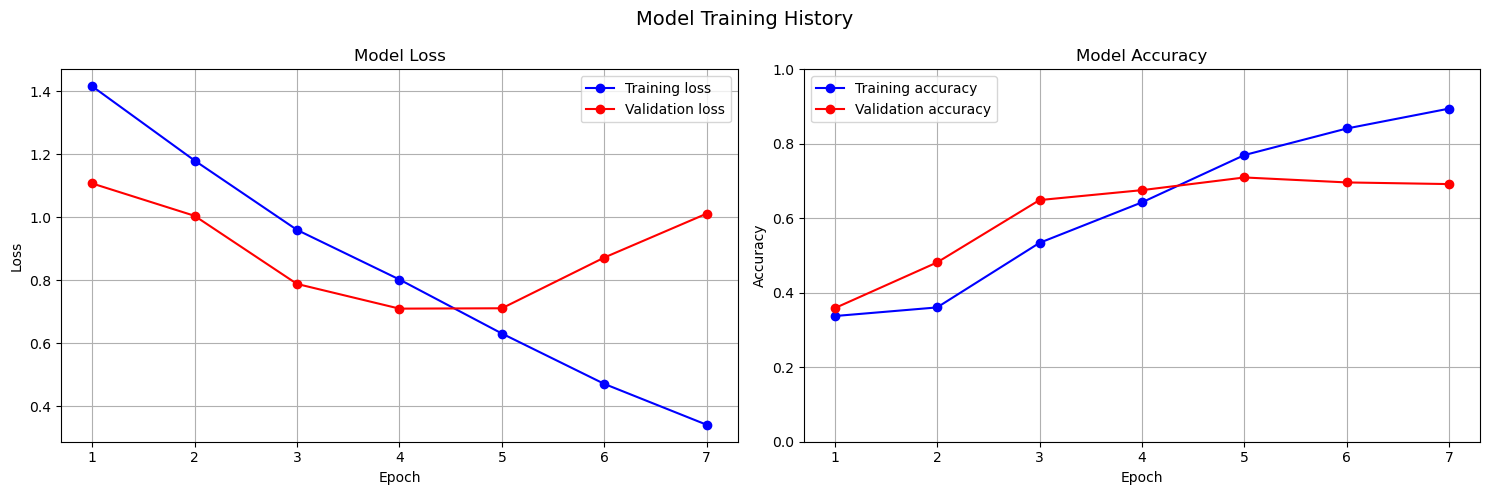


Final Training Metrics:
Training loss: 0.3417
Validation loss: 1.0123
Training accuracy: 0.8946
Validation accuracy: 0.6919


In [8]:
evaluator = ModelEvaluator(history,model, classifier.trainer)

# Display training performance
evaluator.plot_training_history()

# Cell 4: Test Set Preparation
Prepares data for model evaluation:
- Processes the raw data using the classifier
- Extracts test set texts and corresponding sentiment labels
- Organizes data into the required format for evaluation

In [10]:
# Process data and prepare test set
classifier.process_data()
test_texts = classifier.processed_data['dataframes']['test']['processed_text'].to_numpy()
test_labels = {'sentiment': classifier.processed_data['model_inputs'][5]['sentiment']}

Creating dataset with 1500 samples per class
Creating balanced dataset with:
- 1500 reviews per class
- 600 sarcastic reviews per class

Final distribution:

Sentiment 0:
- Total samples: 1500
- Natural sarcasm: 329
- Augmented sarcasm: 271
- Total sarcastic: 600 (40.0%)

Sentiment 1:
- Total samples: 1125
- Natural sarcasm: 75
- Augmented sarcasm: 0
- Total sarcastic: 75 (6.7%)

Sentiment 2:
- Total samples: 1171
- Natural sarcasm: 121
- Augmented sarcasm: 0
- Total sarcastic: 121 (10.3%)


# Cell 5: Test Set Evaluation
Performs comprehensive evaluation on the test dataset:
- Runs the model on the prepared test set
- Calculates performance metrics
- Returns detailed evaluation results

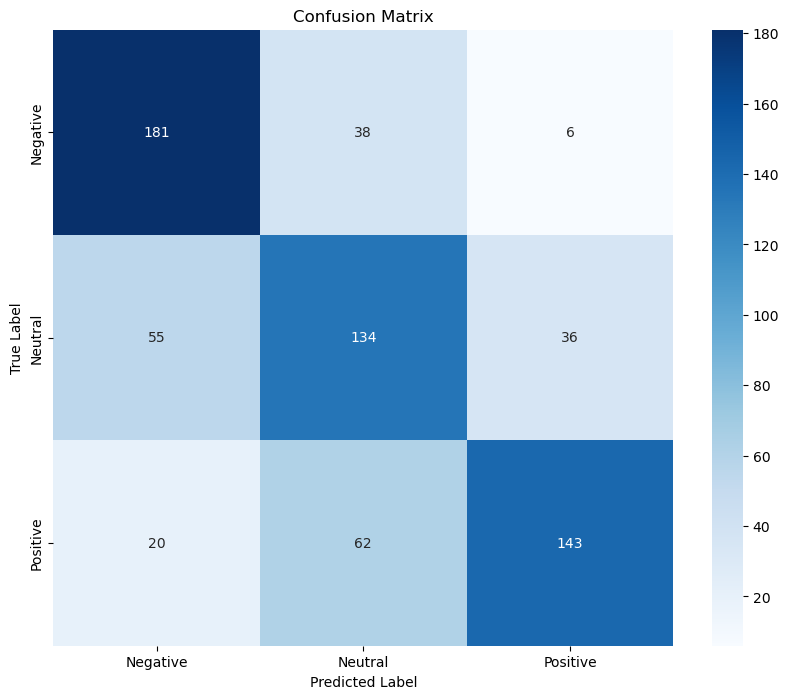


Test Set Metrics:
Overall Accuracy: 0.6785
Macro Avg F1-Score: 0.6780

Class-wise Metrics:

Negative:
Precision: 0.7070
Recall: 0.8044
F1-Score: 0.7526

Neutral:
Precision: 0.5726
Recall: 0.5956
F1-Score: 0.5839

Positive:
Precision: 0.7730
Recall: 0.6356
F1-Score: 0.6976


In [12]:
test_results = evaluator.evaluate_test_set(test_texts, test_labels)

# Cell 6: Edge Case Testing
Evaluates model performance on challenging inputs:
- Tests model behavior with edge cases
- Calculates accuracy specifically for edge cases
- Provides detailed results of edge case handling

In [14]:
edge_case_results = evaluator.test_edge_cases()
print("\nDetailed edge case results:")
print(f"Overall accuracy on edge cases: {edge_case_results['accuracy']:.4f}")


Edge Case Analysis:

Test Case 1:
Text: I can't deny that this place is amazing. Not a single thing wrong with the food or service!
Expected: Positive
Predicted: Positive
Correct: ✓

Test Case 2:
Text: Never had a bad experience here. The food isn't anything less than perfect.
Expected: Positive
Predicted: Negative
Correct: ✗

Test Case 3:
Text: Not once have I been disappointed by their service. The staff isn't unfriendly at all.
Expected: Positive
Predicted: Negative
Correct: ✗

Test Case 4:
Text: Yeah right, like this restaurant could possibly get ANY better! *chef's kiss* Absolutely perfect!
Expected: Positive
Predicted: Positive
Correct: ✓

Test Case 5:
Text: Oh sure, just RUIN my diet with your impossibly delicious desserts! How dare you be this good!
Expected: Positive
Predicted: Negative
Correct: ✗

Test Case 6:
Text: Just what I needed - another restaurant to be obsessed with! 🙄 Now I'll have to keep coming back!
Expected: Positive
Predicted: Negative
Correct: ✗

Test Case 7:

# Cell 7: User Input Testing
Tests the model with user inputs:
- Uses sample given reviews
- prints the model prediction

In [16]:
# Test with some sample inputs
sample_texts = [
    "This restaurant exceeded all my expectations! The food was incredible!", # POSITIVE
    "The service was so slow and the food was cold. Never coming back.", # NEGATIVE
    "It was an okay experience, nothing special but not terrible either." # NEUTRAL
]

for text in sample_texts:
    result = evaluator.test_user_input(text)
    print("\n" + "="*50)


Sentiment Analysis Results:
Input Text: This restaurant exceeded all my expectations! The food was incredible!

Predicted Sentiment: Positive

Class Probabilities:
Negative: 0.2208
Neutral: 0.2195
Positive: 0.5596


Sentiment Analysis Results:
Input Text: The service was so slow and the food was cold. Never coming back.

Predicted Sentiment: Negative

Class Probabilities:
Negative: 0.5127
Neutral: 0.2545
Positive: 0.2328


Sentiment Analysis Results:
Input Text: It was an okay experience, nothing special but not terrible either.

Predicted Sentiment: Neutral

Class Probabilities:
Negative: 0.3423
Neutral: 0.3964
Positive: 0.2613

